# Lecture 2 
## Warning: make sure you run the cells in the correct order

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [2, 2] # inches
mpl.rcParams['font.size'] = 8

# Define a function to do the most common plotting task
def xyplot(x1=None, y1=None, x2=None, y2=None, x3=None, y3=None, title=None, fname=None):
    plt.figure()
    if x1 is not None and y1 is not None:
        plt.plot(x1,y1,'b.')
    if x2 is not None and y2 is not None:
        plt.plot(x2,y2,'k-')
    if x3 is not None and y3 is not None:
        plt.plot(x3,y3,'r-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname)

Let us now try some validation. Let's generate a new 50-point dataset.

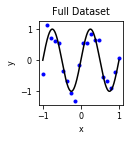

In [26]:
# First, define the function using a lambda expression because it is very simple
f = lambda x: np.sin(2*np.pi*x)
np.random.seed(123123)
# We randomise the order
x = np.atleast_2d(np.random.permutation(np.linspace(-1,1,20)))
y = f(x) + 0.25*np.random.randn(x.size)
# High-resolution noise-free dataset
xt = np.linspace(-1,1,1000)
yt = f(xt)
# Combine the x and y coordinates into a single nump array so that we can split them up into the different sets more easily.
D = np.concatenate([x.T,y.T],axis=1)
xyplot(D[:,0],D[:,1],x2=xt,y2=yt,title='Full Dataset', fname="../figures/regression/dataset.png")

In [27]:
# Split the dataset, remembering that we randomised the order of the data points.
TrainSet = D[0:10]
ValidationSet = D[10:15]
TestSet = D[15:20]

[0.09213264]
[ 0.09213264 -0.22529499]
[ 0.39407035 -0.2526557  -0.68039646]
[ 0.43976177 -0.83284757 -0.75093755  0.80624627]
[ 0.64750252 -0.95247118 -2.28229652  0.93512821  1.49198105]
[  0.27550179   2.69230294  -1.32204151 -12.44296764   0.89176689
  10.0250933 ]
[  0.39465728   2.62886422  -3.6284813  -12.19667665   7.18269995
   9.83914718  -4.14010242]
[  0.22484979   4.25165084  -2.6462273  -23.92365197   5.41183184
  32.7016777   -3.18177777 -12.77104196]
[  0.2251964    4.25402961  -2.67469523 -23.93832037   5.58527033
  32.72933687  -3.49425856 -12.78642303   0.16721231]
[   0.59110287   -0.48525755   -1.91155116   28.72214885   -9.51287701
 -155.40503262   28.41696569  248.83457565  -17.77477971 -121.40928074]


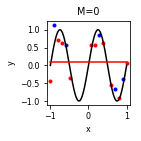

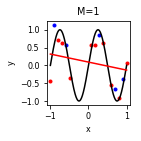

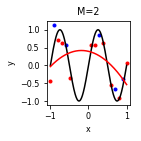

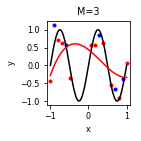

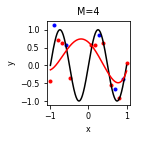

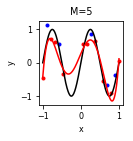

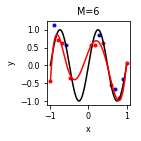

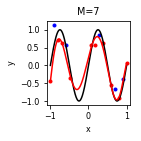

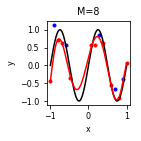

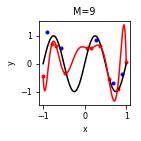

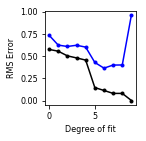

In [28]:
# Define the models. We will look a polynomials of order 1 to 10
# Create empty lists for the results.
weights = []
train_error = []
validation_error = []
max_order=10
for i in range(max_order):
    PhiTrain = np.array([pow(TrainSet[:,0],j) for j in range(0,i+1)]).transpose()
    PhiValid = np.array([pow(ValidationSet[:,0],j) for j in range(0,i+1)]).transpose()
    # Train the model
    w = np.linalg.solve(np.matmul(PhiTrain.transpose(),PhiTrain), np.matmul(PhiTrain.transpose(),TrainSet[:,1]))
    print(w)
    weights.append(w)
    # Compute the error on the training set
    train_error.append(np.sqrt(np.average(pow(TrainSet[:,1]-np.matmul(PhiTrain,w),2))))
    # Compute the error on the validation set
    validation_error.append(np.sqrt(np.average(pow(ValidationSet[:,1]-np.matmul(PhiValid,w),2))))
    plt.figure()
    # Plot the training data
    plt.plot(TrainSet[:,0],TrainSet[:,1],'r.')
    # Plot the validation data
    plt.plot(ValidationSet[:,0],ValidationSet[:,1],'b.')
    # Plot the real trend line
    plt.plot(xt,yt,'k-')
    # Plot the high-res fitted curve
    plt.plot(xt,np.matmul(np.array([pow(xt,j) for j in range(0,i+1)]).transpose(),w),'r-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('M='+str(i))
    plt.tight_layout()
    plt.savefig("../figures/regression/Validation-M="+str(i)+".pdf")
# plot the training and validation errors
plt.figure()
plt.plot(np.linspace(0,max_order-1,max_order),train_error, 'k.-')
plt.plot(np.linspace(0,max_order-1,max_order),validation_error, 'b.-')
plt.xlabel('Degree of fit')
plt.ylabel('RMS Error')
plt.tight_layout()
plt.savefig('../figures/regression/Validation-Errors.pdf')


Our conclusion is that whilst a fit of order 9 is best on the training data, it fails to generalise to the test data and performs even worse on this than that simplest models. We also see that the low-order models have similar training and test error - the model is biased (error is high) but has low variance. Our conclusion from this would be that a model of order 5 or 6 would be appropriate for this dataset.

Having chosen this model, we can then perform a final evaluation on our test set:

In [29]:
# Get the weights from the list of weights
w = weights[5]
PhiTest = np.array([pow(TestSet[:,0],j) for j in range(0,6)]).transpose()
test_error = np.sqrt(np.average(pow(TestSet[:,1]-np.matmul(PhiTest,w),2)))
print(test_error)

0.6826791282612596


This is not especially meaningful on its own and is usually referred to when comparing multiple different methods.

## Cross Validation

We will now perform a cross validation analysis of the data. We will do a five-fold analysis.

First, we split the data into five.

In [54]:
# Split the dataset, remembering that we randomised the order of the data points.
Folds = [ D[0:4], D[4:8], D[8:12], D[12:16], D[16:20] ]

In [81]:
# Define the models. We will look a polynomials of order 1 to 10
# Create empty lists for the results.

max_order=10
nfolds = 5
mean_train_error = []
mean_valid_error = []
for i in range(max_order):
    train_error = []
    validation_error = []
    for j in range(nfolds):
        Valid = Folds[j]
        Train = np.concatenate(Folds[:j]+Folds[j+1:])
        PhiTrain = np.array([pow(Train[:,0],j) for j in range(0,i+1)]).transpose()
        PhiValid = np.array([pow(Valid[:,0],j) for j in range(0,i+1)]).transpose()
        # Train the model
        w = np.linalg.solve(np.matmul(PhiTrain.transpose(),PhiTrain), np.matmul(PhiTrain.transpose(),Train[:,1]))
        # Compute the error on the training set
        train_error.append(np.sqrt(np.average(pow(Train[:,1]-np.matmul(PhiTrain,w),2))))
        # Compute the error on the validation set
        validation_error.append(np.sqrt(np.average(pow(Valid[:,1]-np.matmul(PhiValid,w),2))))
    mean_train_error.append(np.mean(train_error))
    mean_valid_error.append(np.mean(validation_error))
print("Order & Train & Valid \\\\")
for i in range(max_order):
    print("    {0:d} & {1:5.3f} & {2:5.3f} \\\\".format(i,mean_train_error[i],np.mean(mean_valid_error[i])))

Order & Train & Valid \\
    0 & 0.701 & 0.749 \\
    1 & 0.683 & 0.738 \\
    2 & 0.676 & 0.807 \\
    3 & 0.626 & 0.998 \\
    4 & 0.624 & 1.004 \\
    5 & 0.279 & 0.482 \\
    6 & 0.266 & 0.668 \\
    7 & 0.205 & 0.811 \\
    8 & 0.191 & 1.294 \\
    9 & 0.168 & 3.160 \\


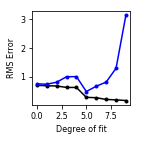

In [82]:
# plot the training and validation errors
plt.figure()
plt.plot(np.linspace(0,max_order-1,max_order),mean_train_error, 'k.-')
plt.plot(np.linspace(0,max_order-1,max_order),mean_valid_error, 'b.-')
plt.xlabel('Degree of fit')
plt.ylabel('RMS Error')
plt.tight_layout()
plt.savefig('../figures/regression/Cross-Validation-Errors.pdf')